# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [14]:
# Define transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler

## YOUR CODE HERE ##
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

testl_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##

dataset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transforms)

batch_size = 64
validation_split = .25
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)




# Create test set and define test dataloader

testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [18]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        image = image / 2 + 0.5
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

car


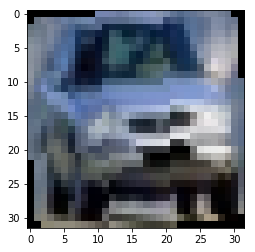

frog


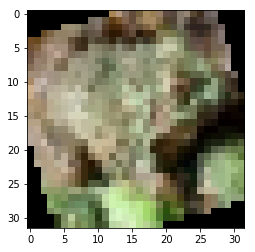

cat


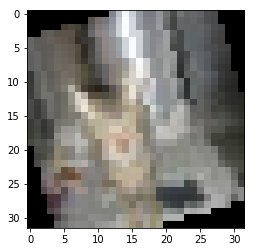

horse


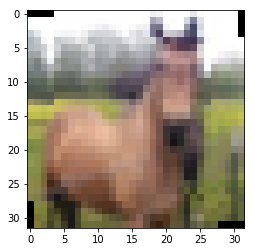

dog


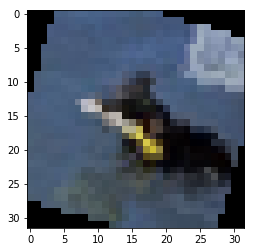

In [20]:
# Explore data
## YOUR CODE HERE ##

show5(train_loader)

In [21]:
next(iter(trainloader))[0].shape

torch.Size([64, 3, 32, 32])

In [22]:
32*32*3

3072

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [40]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 10)

        
        self.dropout=nn.Dropout(p=0.2)
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [41]:
## YOUR CODE HERE ##

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)



## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [42]:
## YOUR CODE HERE ##

epochs = 20
steps = 0

model.to(device);

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(validation_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(validation_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validation_loader)))


Epoch: 1/20..  Training Loss: 1.997..  Test Loss: 1.905..  Test Accuracy: 0.308
Epoch: 2/20..  Training Loss: 1.915..  Test Loss: 1.871..  Test Accuracy: 0.328
Epoch: 3/20..  Training Loss: 1.882..  Test Loss: 1.939..  Test Accuracy: 0.314
Epoch: 4/20..  Training Loss: 1.856..  Test Loss: 1.853..  Test Accuracy: 0.331
Epoch: 5/20..  Training Loss: 1.846..  Test Loss: 1.861..  Test Accuracy: 0.322
Epoch: 6/20..  Training Loss: 1.840..  Test Loss: 1.857..  Test Accuracy: 0.321
Epoch: 7/20..  Training Loss: 1.839..  Test Loss: 1.833..  Test Accuracy: 0.352
Epoch: 8/20..  Training Loss: 1.830..  Test Loss: 1.852..  Test Accuracy: 0.334
Epoch: 9/20..  Training Loss: 1.816..  Test Loss: 1.819..  Test Accuracy: 0.352
Epoch: 10/20..  Training Loss: 1.812..  Test Loss: 1.829..  Test Accuracy: 0.353
Epoch: 11/20..  Training Loss: 1.818..  Test Loss: 1.855..  Test Accuracy: 0.337
Epoch: 12/20..  Training Loss: 1.816..  Test Loss: 1.854..  Test Accuracy: 0.339
Epoch: 13/20..  Training Loss: 1.814.

Plot the training loss (and validation loss/accuracy, if recorded).

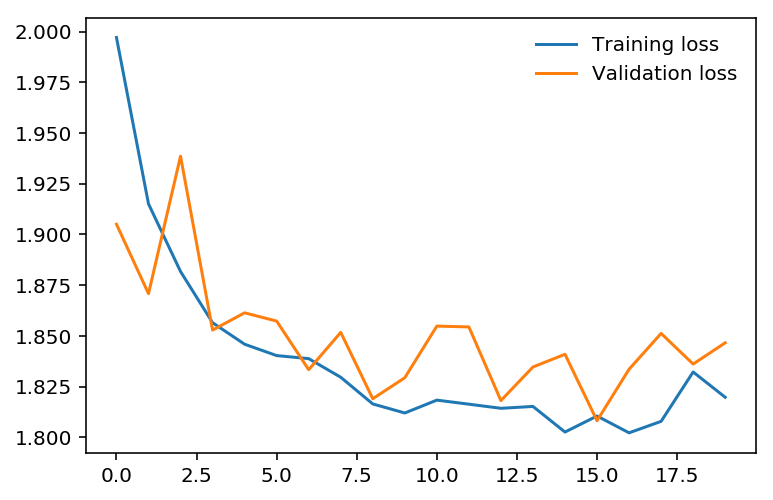

In [43]:
## YOUR CODE HERE ##

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [44]:
## YOUR CODE HERE ##

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
print("Accuracy: {:.3f}".format(accuracy/len(testloader)))

Accuracy: 0.725


In [15]:
len(testloader)

157

## Saving your model
Using `torch.save`, save your model for future loading.

In [45]:
## YOUR CODE HERE ##
checkpoint = {'input_size': 3072,
              'output_size': 10,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

With the results presented above, I would recommend to build our own model.

* We obtained an accuracy of ~73%, and this accuracy was obtained with a rather simple model (only one fully connected Neural Network). This already outperforms Detectocorp
* As shown in the literature, with modern techniques it is possible to achieve accuracies higher than 90%, that outperform DetectoCorp's model
* To achieve this accuracy, I used a feedforward network with 5 distinct layers. The model was trained in 20 epochs (However, after approx. 8 epochs, even when using dropout, we started noticing some overfitting)
* By applying additional techniques, it would be possible to get closer to the results reported in the literature. For example we could apply:

    * Different network structure: We could try adding additional layers or changing activation functions in the fully connected layer
    * Transfer learning: We could use state-of-the-art pretrained models like DenseNet or ResNet, that have convolutional layers trained on extremely large datasets. Using this strategy, we could leverage the learning of thosse models and adapt it to the final fully connected network, that would be trained on the CIFAR dataset.
    * Convolutional networks (CNN): We could try to train a CNN, that increases the accuracy of predictions by assigning different importance to elements within the image. As stated by Sumit Saha (2018) in Towards Data Science, CNN outperform traditional feedforward networks by identifying complex spatial and temporal correlations within the data. 
    
References

* Saha, Sumit (2018) A comprehensive guide to Convolutional Neural Networks. Available in https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).